# **Final Project**

##### 0. Libary & setting

In [25]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
from itertools import combinations


# multiple output in notebook without print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



Running trials with discount rate: 0.9
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10

Running trials with discount rate: 0.95
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10

Running trials with discount rate: 0.99
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10


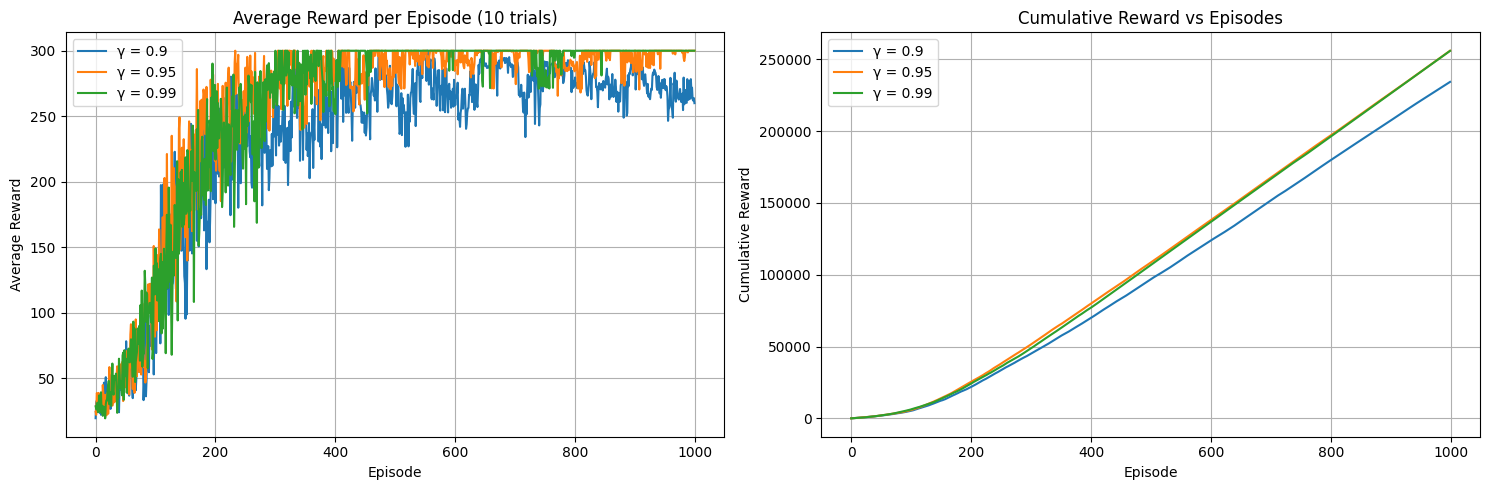

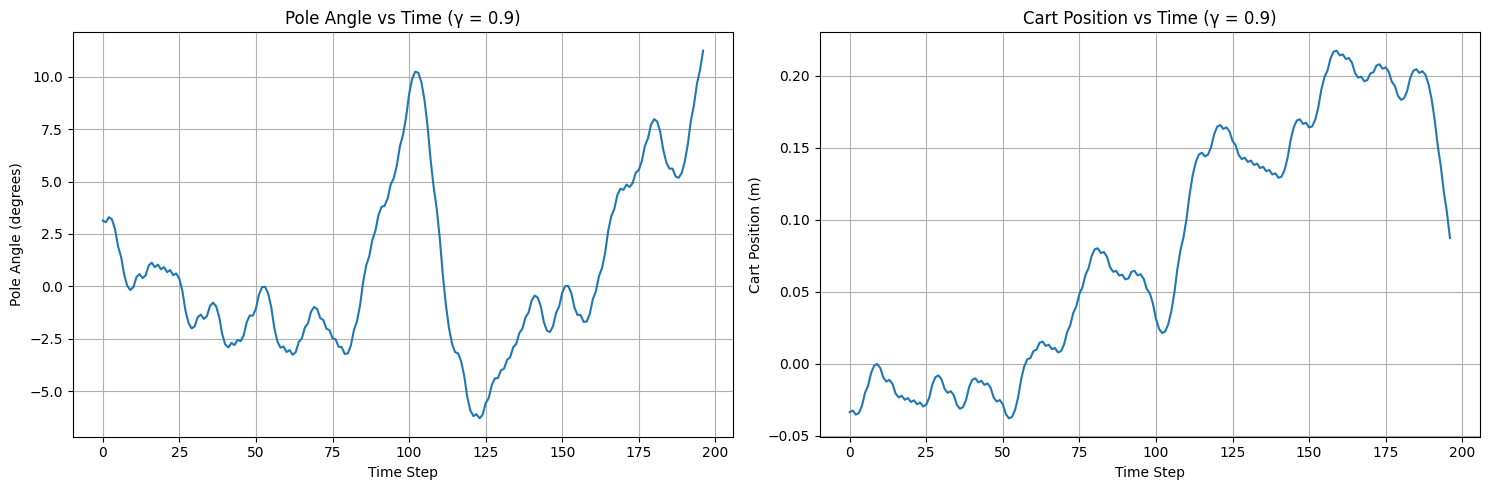

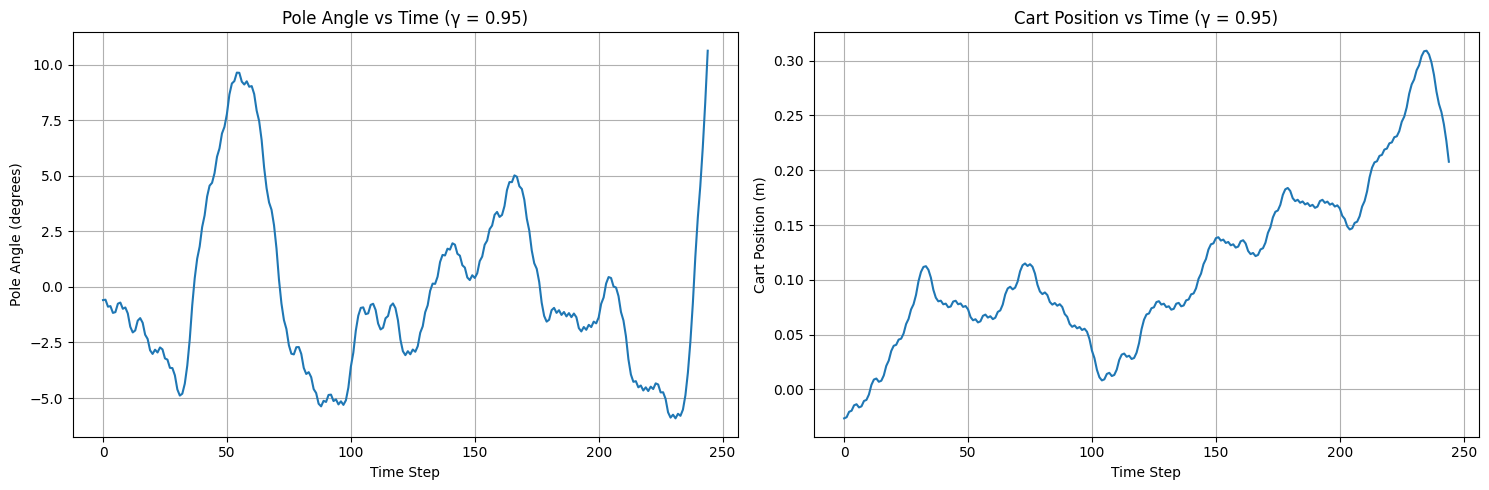

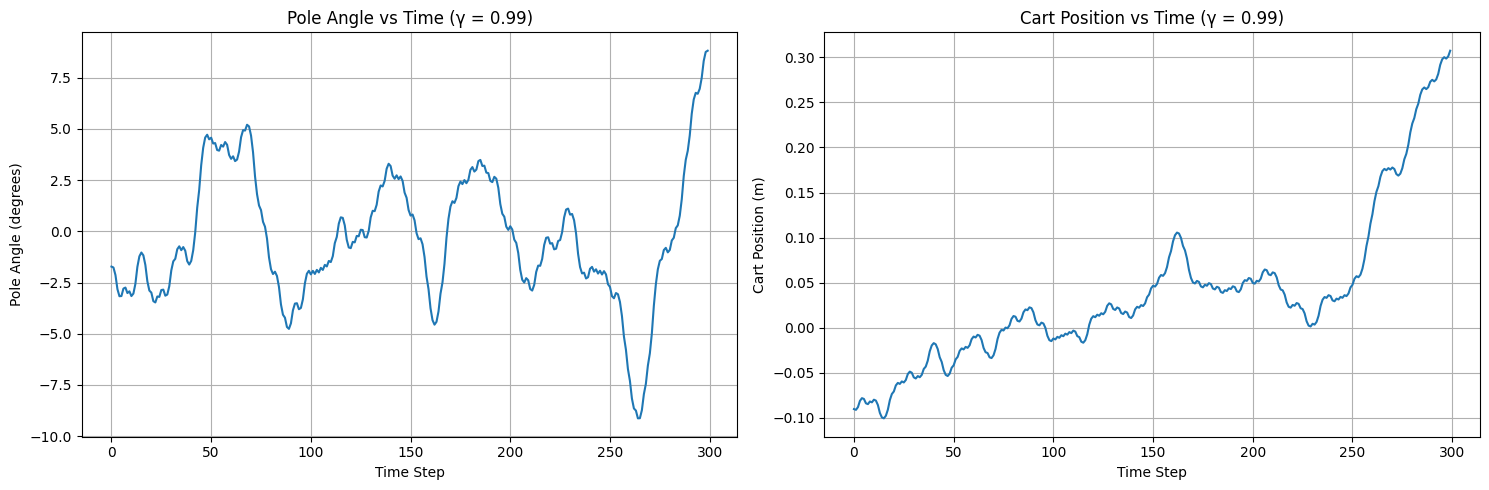

In [44]:
### Define CartePoleDynamics including environment, parameter, state space setting 
class CartPoleDynamics:
    def __init__(self):
        # System parameters
        self.M = 1.0  # Mass of the cart
        self.m = 0.1  # Mass of the pole
        self.g = -9.8  # Gravity
        self.l = 0.5  # Length of the pole
        self.mu_c = 0.0005  # Friction for the cart
        self.mu_p = 0.000002  # Friction for the pole
        self.delta_t = 0.02  # Time step
        self.actions = [-10, 10]  # Available actions (forces in Newtons)
        
        # State space discretization (Boxes system)
        self.theta_boxes = np.array([-12, -6, -1, 0, 1, 6, 12]) * np.pi / 180  # radians
        self.x_boxes = np.array([-2.4, -0.8, 0.8, 2.4])  # meters
        self.theta_dot_boxes = np.array([-50, 0, 50]) * np.pi / 180  # radians/s
        self.x_dot_boxes = np.array([-0.5, 0, 0.5])  # m/s
        
        # State space size
        self.state_space_size = (
            len(self.theta_boxes) + 1, # 7+1=8 regions for theta
            len(self.theta_dot_boxes) + 1, # 3+1=4 regions for theta
            len(self.x_boxes) + 1, # 4+1=5 regions for theta
            len(self.x_dot_boxes) + 1 # 3+1=4 regions for theta
        )

    def compute_accelerations(self, theta, theta_dot, x_dot, F):
        """Compute angular and linear accelerations based on the model"""
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        
        # Calculate theta_ddot (from equation 1)
        numerator = (self.g * sin_theta + 
                    cos_theta * ((-F - self.m * self.l * theta_dot**2 * sin_theta + 
                                self.mu_c * np.sign(x_dot)) / (self.M + self.m)) - 
                    self.mu_p * theta_dot / (self.m * self.l))
        denominator = self.l * (4.0/3.0 - (self.m * cos_theta**2) / (self.M + self.m))
        theta_ddot = numerator / denominator
        
        # Calculate x_ddot (from equation 1)
        x_ddot = (F + self.m * self.l * (theta_dot**2 * sin_theta - theta_ddot * cos_theta) - 
                 self.mu_c * np.sign(x_dot)) / (self.M + self.m)
        
        return theta_ddot, x_ddot
    
    def update_state(self, state, action):
        """Update state using Euler integration (equation 2)"""
        theta, theta_dot, x, x_dot = state
        
        theta_ddot, x_ddot = self.compute_accelerations(theta, theta_dot, x_dot, action)
        
        # Euler integration
        x_dot_new = x_dot + self.delta_t * x_ddot
        x_new = x + self.delta_t * x_dot
        theta_dot_new = theta_dot + self.delta_t * theta_ddot
        theta_new = theta + self.delta_t * theta_dot
        
        return np.array([theta_new, theta_dot_new, x_new, x_dot_new])

    def discretize_state(self, state):
        """Discretize state using the Boxes system"""
        theta, theta_dot, x, x_dot = state
        
        theta_idx = np.digitize(theta, self.theta_boxes)
        theta_dot_idx = np.digitize(theta_dot, self.theta_dot_boxes)
        x_idx = np.digitize(x, self.x_boxes)
        x_dot_idx = np.digitize(x_dot, self.x_dot_boxes)
        
        return (theta_idx, theta_dot_idx, x_idx, x_dot_idx)

    def is_terminal(self, state):
        """Check if state is terminal based on angle and position limits"""
        theta, _, x, _ = state
        return abs(theta) > 12 * np.pi / 180 or abs(x) > 2.4

    def reset(self):
        """Reset state to small random values near center"""
        theta = np.random.uniform(-0.1, 0.1)
        theta_dot = np.random.uniform(-0.1, 0.1)
        x = np.random.uniform(-0.1, 0.1)
        x_dot = np.random.uniform(-0.1, 0.1)
        return np.array([theta, theta_dot, x, x_dot])

### Define TemporalDiffence class for Implementing TD
class TemporalDifference:
    def __init__(self):
        self.dynamics = CartPoleDynamics()
        self.epsilon_start = 1.0 # start with 100% exploration
        self.epsilon_min = 0.01 # Minimum exploration rate
        self.epsilon_decay = 0.995 # Decay rate for exploration
        self.learning_rate = 0.1 # Learning rate(alpha)
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros(self.dynamics.state_space_size + (2,))  # including 2 actions: -10N or +10N

    def get_action(self, state_discrete, epsilon):
        """Epsilon-greedy action selection"""
        """Select action that maximize Q-value """
        if np.random.random() < epsilon:
            return np.random.randint(2)  # Random action: 0 or 1
        return np.argmax(self.q_table[state_discrete])

    def get_reward(self, state):
        """Compute reward based on state"""
        # +1 reward while pole is upright and cart is within bounds
        if not self.dynamics.is_terminal(state):
            return 1.0
        return 0.0  # Terminal state

    def run_trial(self, discount_rate=0.95, n_episodes=1000):
        """Run one complete trial"""
        epsilon = self.epsilon_start
        episode_rewards = []
        cumulative_rewards = []
        total_reward = 0
        last_100_rewards = deque(maxlen = 100)
        successful_episode_data = None
        max_steps = 300  # Maximum steps per episode

        for episode in range(n_episodes):
            state = self.dynamics.reset()
            episode_reward = 0
            states_history = {'time': [], 'theta': [], 'x': []}
            
            for step in range(max_steps):
                # Record state
                states_history['time'].append(step)
                states_history['theta'].append(state[0] * 180 / np.pi)  # Convert to degrees
                states_history['x'].append(state[2])
                
                # Get action
                state_discrete = self.dynamics.discretize_state(state) 
                action_idx = self.get_action(state_discrete, epsilon)
                action = self.dynamics.actions[action_idx] # pick -10 or 10
                
                # Take action
                next_state = self.dynamics.update_state(state, action)
                reward = self.get_reward(next_state)
                done = self.dynamics.is_terminal(next_state)
                
                # Q-learning update
                next_state_discrete = self.dynamics.discretize_state(next_state)
                old_value = self.q_table[state_discrete + (action_idx,)]
                next_max = np.max(self.q_table[next_state_discrete])
                # Blending the old and new values for updating Q-value
                new_value = (1 - self.learning_rate) * old_value + \
                           self.learning_rate * (reward + discount_rate * next_max)
                self.q_table[state_discrete + (action_idx,)] = new_value
                
                state = next_state
                episode_reward += reward
                
                if done: # epsode termination check
                    break

            # Store successful episode data
            if episode_reward >= 195 and successful_episode_data is None:
                successful_episode_data = states_history.copy()

            # Update tracking variables
            episode_rewards.append(episode_reward)
            total_reward += episode_reward
            cumulative_rewards.append(total_reward)
            last_100_rewards.append(episode_reward)
            
            # Decay epsilon
            epsilon = max(self.epsilon_min, epsilon * self.epsilon_decay)
            
            # Check if solved
           # if len(last_100_rewards) == 100 and np.mean(last_100_rewards) >= 195.0:
           #     print(f"Solved at episode {episode}! Average reward: {np.mean(last_100_rewards):.2f}")

        return episode_rewards, cumulative_rewards, successful_episode_data

def run_experiments():
    agent = TemporalDifference()
    discount_rates = [0.9, 0.95, 0.99]
    results = {}
    
    for gamma in discount_rates:
        print(f"\nRunning trials with discount rate: {gamma}")
        trial_episode_rewards = []
        trial_cumulative_rewards = []
        trial_successful_states = None
        
        # Run 10 trials
        for trial in range(10):
            print(f"Trial {trial + 1}/10")
            episode_rewards, cumulative_rewards, successful_states = agent.run_trial(gamma)
            trial_episode_rewards.append(episode_rewards)
            trial_cumulative_rewards.append(cumulative_rewards)
            if successful_states is not None and trial_successful_states is None:
                trial_successful_states = successful_states
        
        # Average results across trials
        avg_episode_rewards = np.mean(trial_episode_rewards, axis=0)
        avg_cumulative_rewards = np.mean(trial_cumulative_rewards, axis=0)
        
        results[gamma] = {
            'episode_rewards': avg_episode_rewards,
            'cumulative_rewards': avg_cumulative_rewards,
            'successful_states': trial_successful_states
        }
    
    return results

def plot_results(results):
    # Plot episode rewards
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for gamma, data in results.items():
        plt.plot(data['episode_rewards'], label=f'γ = {gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode (10 trials)')
    plt.legend()
    plt.grid(True)
    
    # Plot cumulative rewards
    plt.subplot(1, 2, 2)
    for gamma, data in results.items():
        plt.plot(data['cumulative_rewards'], label=f'γ = {gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward vs Episodes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show();
    
    # Plot successful episode states
    for gamma, data in results.items():
        if data['successful_states'] is not None:
            plt.figure(figsize=(15, 5))
            
            # Plot theta
            plt.subplot(1, 2, 1)
            plt.plot(data['successful_states']['time'], 
                    data['successful_states']['theta'])
            plt.xlabel('Time Step')
            plt.ylabel('Pole Angle (degrees)')
            plt.title(f'Pole Angle vs Time (γ = {gamma})')
            plt.grid(True)
            
            # Plot x
            plt.subplot(1, 2, 2)
            plt.plot(data['successful_states']['time'], 
                    data['successful_states']['x'])
            plt.xlabel('Time Step')
            plt.ylabel('Cart Position (m)')
            plt.title(f'Cart Position vs Time (γ = {gamma})')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show();


def main():
    # Run experiments
    results = run_experiments()
    
    # Plot results
    plot_results(results)

if __name__ == "__main__":
    main()